/home/kamil/Documents/envs/dsb/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
neptune: Executing in Offline Mode.


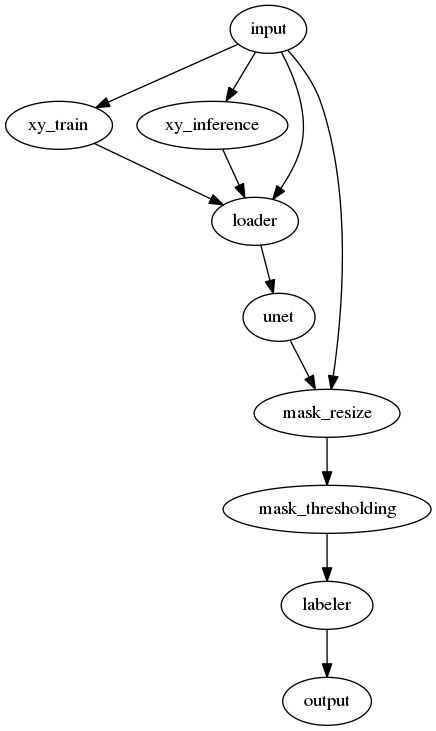

In [5]:
from pipelines import unet
from pipeline_config import SOLUTION_CONFIG

pipe = unet(SOLUTION_CONFIG, train_mode=True)
pipe